In [29]:
import numpy as np
import os
from os import listdir
import matplotlib.pyplot as plt

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import confusion_matrix

In [7]:
!pip install pandas

     ---------------------------------------- 10.4/10.4 MB 8.4 MB/s eta 0:00:00
     -------------------------------------- 499.4/499.4 kB 7.9 MB/s eta 0:00:00


In [10]:
#Load the 2nd dataset
import pandas as pd

#The data set : https://www.kaggle.com/datasets/debanga/facial-expression-recognition-challenge?resource=download
#Rename the folder as faceEmotion_dataset_v2

# read the CSV file
df = pd.read_csv("faceEmotion_dataset_v2/icml_face_data.csv")

num_classes = 7

# print the first few rows of the DataFrame
print(df.head())

   emotion     Usage                                             pixels
0        0  Training  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1        0  Training  151 150 147 155 148 133 111 140 170 174 182 15...
2        2  Training  231 212 156 164 174 138 161 173 182 200 106 38...
3        4  Training  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4        6  Training  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [11]:
def remove_emotion(df, numberEmotion):
    '''Remove the "numberEmotion" from the dataset df'''
    maskEmotion = df["emotion"] != numberEmotion

    return df.loc[maskEmotion]

# If we want to remove an emotion from the data, we can use this code
# df = remove_emotion(df, 2)
# df = remove_emotion(df, 3)
# df = remove_emotion(df, 6)
df = df.reset_index()
df

,index,emotion,Usage,pixels
0,0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
...,...,...,...,...
35882,35882,6,PrivateTest,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...
35883,35883,3,PrivateTest,178 174 172 173 181 188 191 194 196 199 200 20...
35884,35884,0,PrivateTest,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...
35885,35885,3,PrivateTest,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...


In [12]:
#Split between training and test
maskTraining = df[" Usage"] == "Training"
maskTest = [not elem for elem in maskTraining]

df_train = df.loc[maskTraining]
df_test = df.loc[maskTest]

In [13]:
def list_string_to_arrayImages(L, sizeX=48, sizeY=48):

    Images_Dataset = []
    for k in range(L.index[0], L.index[-1] + 1):
        # split the string into a list of strings
        # lst = df[" pixels"][k].split()
        lst = L[k].split()

        # convert the strings to integers using map() and a lambda function
        lst = list(map(lambda x: int(x), lst))

        Images_Dataset.append(lst)
    Images_Dataset = np.array(Images_Dataset)
    Images_Dataset = Images_Dataset.reshape(Images_Dataset.shape[0], sizeX , sizeY)
    Images_Dataset = Images_Dataset.astype('float32')
    Images_Dataset /= 255
    return Images_Dataset

In [14]:
#Proprocess dataset and get X_train and X_test
X_train = list_string_to_arrayImages(df_train[" pixels"])
X_test = list_string_to_arrayImages(df_test[" pixels"])

print((X_train).shape)
print((X_test).shape)


(28709, 48, 48)
(7178, 48, 48)


In [15]:
#get y_train and y_test
Labels_train = list(df_train["emotion"])
Labels_test = list(df_test["emotion"])

In [16]:
#change the shape of the object labels
y_train = to_categorical(Labels_train, num_classes) 
y_test = to_categorical(Labels_test, num_classes) 

In [17]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    fig, axs = plt.subplots(1, 2,  figsize=(12, 6))
    for l in loss_list:
        axs[0].plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        axs[0].plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    axs[0].set(title='Loss', xlabel='Epochs', ylabel='Loss')
    axs[0].grid()
    axs[0].legend()
    
    ## Accuracy
    for l in acc_list:
        axs[1].plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        axs[1].plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    axs[1].set(title='Accuracy', xlabel='Epochs', ylabel='Accuracy')
    axs[1].grid()
    axs[1].legend()
    plt.show()

Epoch 1/10
898/898 [==============================] - 24s 26ms/step - loss: 1.6065 - accuracy: 0.3763
Epoch 2/10
898/898 [==============================] - 23s 25ms/step - loss: 1.4487 - accuracy: 0.4545
Epoch 3/10
898/898 [==============================] - 23s 25ms/step - loss: 1.3693 - accuracy: 0.4894
Epoch 4/10
898/898 [==============================] - 22s 25ms/step - loss: 1.3128 - accuracy: 0.5092
Epoch 5/10
898/898 [==============================] - 22s 25ms/step - loss: 1.2596 - accuracy: 0.5332
Epoch 6/10
898/898 [==============================] - 22s 25ms/step - loss: 1.2129 - accuracy: 0.5516
Epoch 7/10
898/898 [==============================] - 22s 25ms/step - loss: 1.1676 - accuracy: 0.5685
Epoch 8/10
898/898 [==============================] - 22s 25ms/step - loss: 1.1292 - accuracy: 0.5868
Epoch 9/10
898/898 [==============================] - 23s 25ms/step - loss: 1.0883 - accuracy: 0.6022
Epoch 10/10
898/898 [==============================] - 22s 25ms/step - loss: 1.053

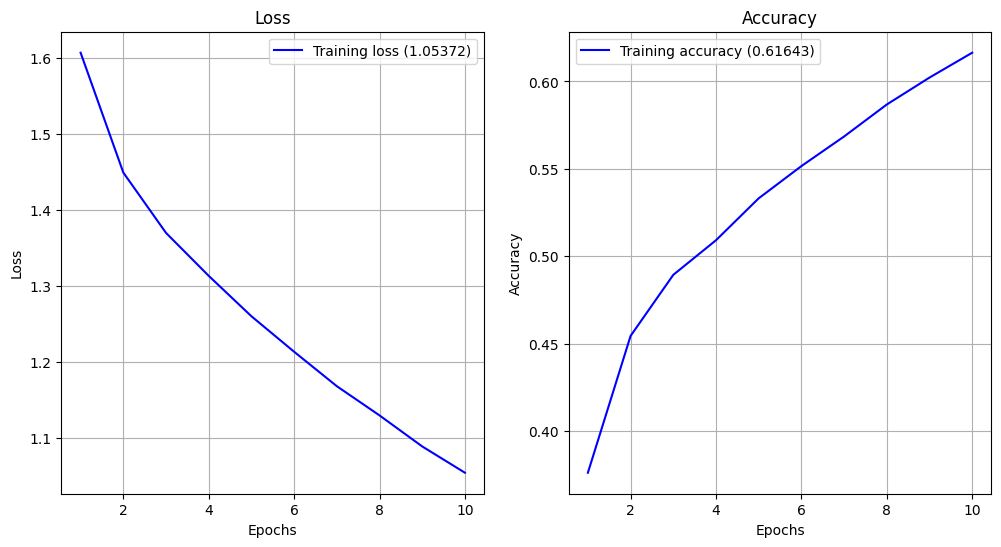

225/225 [==============================] - 2s 9ms/step
Accuracy: 0.48021733073279466
898/898 [==============================] - 8s 9ms/step


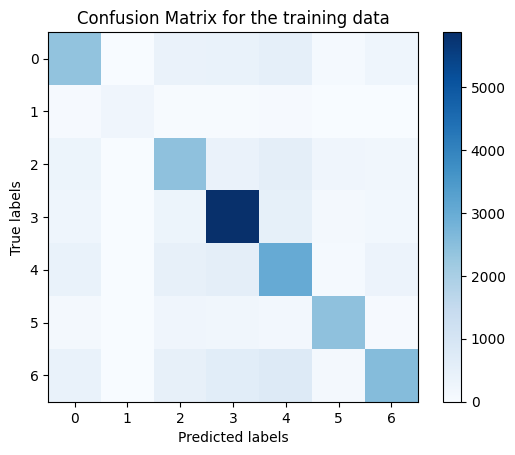

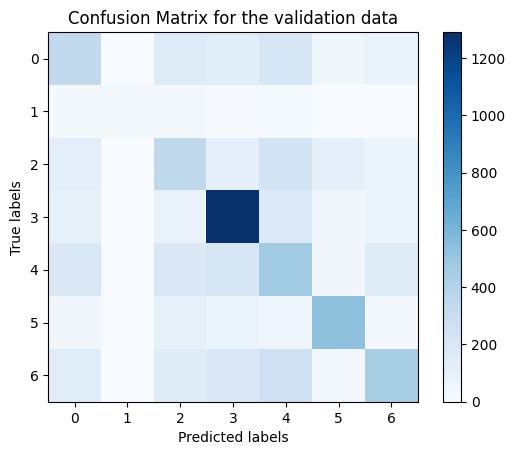

Accuracy by class: [0.35177453027139877, 0.26126126126126126, 0.33984375, 0.7271702367531003, 0.3777064955894146, 0.6401925391095066, 0.35685320356853206]
Precision: [0.34778122 0.85294118 0.32923368 0.63672261 0.33239238 0.64484848
 0.51764706]
Recall: [0.35177453 0.26126126 0.33984375 0.72717024 0.3777065  0.64019254
 0.3568532 ]
F1 score: [0.34976648 0.4        0.33445459 0.67894737 0.3536036  0.64251208
 0.42246759]


In [26]:
# define the model number 1
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

# compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32) # the epochs MUST be incremented, the results are way better

# check model results
plot_history(history)

# predictions  with the test data
predictions = model.predict(X_test)

# calculate the accuracy of the predictions
accuracy = np.mean(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1))
print('Accuracy:', accuracy)

predictions_class_train = np.argmax(model.predict(X_train), axis=1)
# y_test and predictions_class are the true labels and predicted labels, respectively
cm = confusion_matrix(np.argmax(y_train, axis=1), predictions_class_train)
plt.imshow(cm, cmap='Blues')
plt.colorbar()
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for the training data')
plt.show()

predictions_class = np.argmax(predictions, axis=1)
# y_test and predictions_class are the true labels and predicted labels, respectively
cm = confusion_matrix(np.argmax(y_test, axis=1), predictions_class)
plt.imshow(cm, cmap='Blues')
plt.colorbar()
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for the validation data')
plt.show()

from sklearn.metrics import precision_score, recall_score, f1_score

accuracies = []
for i in range(num_classes):
    accuracy = cm[i, i] / cm[i].sum()
    accuracies.append(accuracy)
print("Accuracy by class:", accuracies)

# calculate the precision, recall, and F1 score
precision = precision_score(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1), average=None)
recall = recall_score(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1), average=None)
f1 = f1_score(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1), average=None)

print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f1)

In [30]:
# Good results, very similar to the previous model, but the accuracy increases slowlier than the previous one. It can be due to the Dropout layers,
# added to prevent overfitting. Nevertheless, in the model it has not been observed yet, so they may me unnecessary. Also, the training time increases
# greatly, probably due to the increase of the layer number.
# define the model number 2
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32)

# check model results
plot_history(history)

# predictions  with the test data
predictions = model.predict(X_test)

# calculate the accuracy of the predictions
accuracy = np.mean(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1))
print('Accuracy:', accuracy)

predictions_class_train = np.argmax(model.predict(X_train), axis=1)
# y_test and predictions_class are the true labels and predicted labels, respectively
cm = confusion_matrix(np.argmax(y_train, axis=1), predictions_class_train)
plt.imshow(cm, cmap='Blues')
plt.colorbar()
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for the training data')
plt.show()

predictions_class = np.argmax(predictions, axis=1)
# y_test and predictions_class are the true labels and predicted labels, respectively
cm = confusion_matrix(np.argmax(y_test, axis=1), predictions_class)
plt.imshow(cm, cmap='Blues')
plt.colorbar()
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for the validation data')
plt.show()

from sklearn.metrics import precision_score, recall_score, f1_score

accuracies = []
for i in range(num_classes):
    accuracy = cm[i, i] / cm[i].sum()
    accuracies.append(accuracy)
print("Accuracy by class:", accuracies)

# calculate the precision, recall, and F1 score
precision = precision_score(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1), average=None)
recall = recall_score(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1), average=None)
f1 = f1_score(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1), average=None)

print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f1)

Epoch 1/10
898/898 [==============================] - 206s 228ms/step - loss: 1.6755 - accuracy: 0.3347
Epoch 2/10
898/898 [==============================] - 198s 221ms/step - loss: 1.4788 - accuracy: 0.4273
Epoch 3/10
898/898 [==============================] - 191s 213ms/step - loss: 1.3884 - accuracy: 0.4669
Epoch 4/10
898/898 [==============================] - 194s 216ms/step - loss: 1.3121 - accuracy: 0.4958
Epoch 5/10
898/898 [==============================] - 208s 232ms/step - loss: 1.2411 - accuracy: 0.5258
Epoch 6/10
593/898 [==================>...........] - ETA: 1:09 - loss: 1.1776 - accuracy: 0.5473

In [ ]:
# TODO DESCRIPTION OF THE MODEL
# define the model number 3
model = Sequential()
model.add(Dense(20, activation='relu', input_shape=(48, 48, 1)))
model.add(Dropout(0.05))
model.add(Dense(20, activation='relu', input_shape=(48, 48, 1)))
model.add(Dropout(0.05))
model.add(Dense(20, activation='relu', input_shape=(48, 48, 1)))
model.add(Flatten())
model.add(Dense(100, activation='relu', input_shape=(48, 48, 1)))
model.add(Dropout(0.05))
model.add(Dense(100, activation='relu', input_shape=(48, 48, 1)))
model.add(Dense(num_classes, activation='sigmoid', ))

# compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32)

# check model results
plot_history(history)

# predictions  with the test data
predictions = model.predict(X_test)

# calculate the accuracy of the predictions
accuracy = np.mean(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1))
print('Accuracy:', accuracy)

predictions_class_train = np.argmax(model.predict(X_train), axis=1)
# y_test and predictions_class are the true labels and predicted labels, respectively
cm = confusion_matrix(np.argmax(y_train, axis=1), predictions_class_train)
plt.imshow(cm, cmap='Blues')
plt.colorbar()
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for the training data')
plt.show()

predictions_class = np.argmax(predictions, axis=1)
# y_test and predictions_class are the true labels and predicted labels, respectively
cm = confusion_matrix(np.argmax(y_test, axis=1), predictions_class)
plt.imshow(cm, cmap='Blues')
plt.colorbar()
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for the validation data')
plt.show()

from sklearn.metrics import precision_score, recall_score, f1_score

accuracies = []
for i in range(num_classes):
    accuracy = cm[i, i] / cm[i].sum()
    accuracies.append(accuracy)
print("Accuracy by class:", accuracies)

# calculate the precision, recall, and F1 score
precision = precision_score(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1), average=None)
recall = recall_score(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1), average=None)
f1 = f1_score(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1), average=None)

print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f1)

In [ ]:
# define the model number 4
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32)

# check model results
plot_history(history)

# predictions  with the test data
predictions = model.predict(X_test)

# calculate the accuracy of the predictions
accuracy = np.mean(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1))
print('Accuracy:', accuracy)

predictions_class_train = np.argmax(model.predict(X_train), axis=1)
# y_test and predictions_class are the true labels and predicted labels, respectively
cm = confusion_matrix(np.argmax(y_train, axis=1), predictions_class_train)
plt.imshow(cm, cmap='Blues')
plt.colorbar()
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for the training data')
plt.show()

predictions_class = np.argmax(predictions, axis=1)
# y_test and predictions_class are the true labels and predicted labels, respectively
cm = confusion_matrix(np.argmax(y_test, axis=1), predictions_class)
plt.imshow(cm, cmap='Blues')
plt.colorbar()
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for the validation data')
plt.show()

from sklearn.metrics import precision_score, recall_score, f1_score

accuracies = []
for i in range(num_classes):
    accuracy = cm[i, i] / cm[i].sum()
    accuracies.append(accuracy)
print("Accuracy by class:", accuracies)

# calculate the precision, recall, and F1 score
precision = precision_score(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1), average=None)
recall = recall_score(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1), average=None)
f1 = f1_score(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1), average=None)

print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f1)

In [10]:
predictions = model.predict(X_test)

# calculate the accuracy of the predictions
accuracy = np.mean(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1))


print('Accuracy:', accuracy)

225/225 [==============================] - 3s 13ms/step
Accuracy: 0.47826692672053495


898/898 [==============================] - 12s 13ms/step


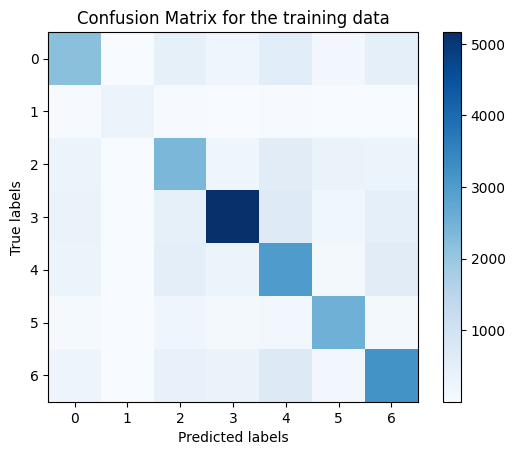

In [11]:
predictions_class_train = np.argmax(model.predict(X_train), axis=1)
# y_test and predictions_class are the true labels and predicted labels, respectively
cm = confusion_matrix(np.argmax(y_train, axis=1), predictions_class_train)
plt.imshow(cm, cmap='Blues')
plt.colorbar()
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for the training data')
plt.show()

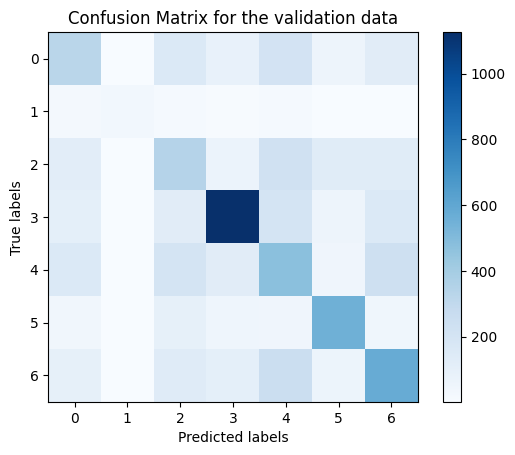

In [12]:
predictions_class = np.argmax(predictions, axis=1)
# y_test and predictions_class are the true labels and predicted labels, respectively
cm = confusion_matrix(np.argmax(y_test, axis=1), predictions_class)
plt.imshow(cm, cmap='Blues')
plt.colorbar()
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for the validation data')
plt.show()

In [13]:
from sklearn.metrics import precision_score, recall_score, f1_score

accuracies = []
for i in range(num_classes):
    accuracy = cm[i, i] / cm[i].sum()
    accuracies.append(accuracy)
print("Accuracy by class:", accuracies)

# calculate the precision, recall, and F1 score
precision = precision_score(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1), average=None)
recall = recall_score(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1), average=None)
f1 = f1_score(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1), average=None)

print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f1)

Accuracy by class: [0.33820459290187893, 0.32432432432432434, 0.3349609375, 0.6347237880496054, 0.38011226944667204, 0.6666666666666666, 0.46715328467153283]
Precision: [0.37543453 0.62068966 0.31788693 0.71492063 0.33450953 0.60612691
 0.45283019]
Recall: [0.33820459 0.32432432 0.33496094 0.63472379 0.38011227 0.66666667
 0.46715328]
F1 score: [0.35584843 0.4260355  0.32620067 0.67243953 0.35585586 0.63495702
 0.45988024]
